In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive/MyDrive'

EARIN_Project


In [3]:
%cd '/content/drive/MyDrive/EARIN_Project'

/content/drive/.shortcut-targets-by-id/1kHAaAnhWhyKF2U7A0MmLX7FNJxbibsA8/EARIN_Project


In [4]:
!ls

bert-base-uncased-vocab.txt  model0.h5	  model512.h5	      trained_lstm_model.pth
embeddings_matrix.pkl	     model128.h5  modelmix.h5	      train.ft.txt.bz2
glove.6B.100d.txt	     model1.h5	  processed_data.pkl


In [5]:
import requests
import os

In [6]:
def download_file(url, filename):
    """
    Download a file from a given URL and save it to a given filename.
    If the file already exists, do nothing.
    """
    if not os.path.exists(filename):
        # send a GET request to the URL
        response = requests.get(url)
        # write the content of the response to a file
        with open(filename, 'wb') as file:
            file.write(response.content)

In [7]:
# Download the BERT vocabulary file if not already present
VOCAB_URL = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"
VOCAB_FILE = "bert-base-uncased-vocab.txt"

download_file(VOCAB_URL, VOCAB_FILE)

In [8]:
import nltk
from nltk.corpus import stopwords

In [9]:
# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import pickle

In [11]:
def save_to_pickle(obj, filename):
    """
    Save an object to a pickle file.
    """
    print(f"Saving {filename} to pickle file...")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def load_from_pickle(filename):
    """
    Load an object from a pickle file if it exists.
    """
    if not os.path.exists(filename):
        return None
    print(f"Loading {filename} from pickle file...")
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [12]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=60befed61e4b45f2c3269922f3800d8557c7bd913f4ebd6551d41396c68bd7e7
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [13]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.6 MB/s eta 0:00:00


In [14]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [15]:
import bz2
import pandas as pd; print(pd.__version__)
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re
import emoji

2.2.2


In [16]:
DetectorFactory.seed = 42

In [17]:
def preprocess_data(sample_size, filename):
    # Load and balance the dataset
    file_path = 'train.ft.txt.bz2'
    positive_reviews = []
    negative_reviews = []

    # we want to use a balanced dataset of sample reviews
    # we pick half negative and half positive reviews
    with bz2.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            label = int(label[-1])
            if label == 1 and len(negative_reviews) < sample_size // 2:
                negative_reviews.append([label, text])
            elif label == 2 and len(positive_reviews) < sample_size // 2:
                positive_reviews.append([label, text])
            if len(positive_reviews) == sample_size // 2 and len(negative_reviews) == sample_size // 2:
                break

    # Combine positive and negative reviews
    data = positive_reviews + negative_reviews
    df = pd.DataFrame(data, columns=['label', 'text'])

    # Function to detect language
    def detect_language(text):
        try:
            return detect(text)
        except LangDetectException:
            return "unknown"

    # Detect language
    df['language'] = df['text'].apply(detect_language)

    # Filter out non-English reviews
    df = df[df['language'] == 'en']
    df = df.drop(columns=['language'])

    # Initialize stopwords
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        # Replace emojis with descriptive words
        text = emoji.demojize(text, delimiters=(" ", " "))
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    # Apply text cleaning to the 'text' column
    df['text'] = df['text'].apply(clean_text)

    # this is a rather simple way to shuffle a DataFrame
    df = df.sample(frac=1,random_state=42)

    return df

In [18]:

SAMPLE_SIZE = 20_000

In [19]:
# %% Load and pre-process dataset, then save using pickle

# Define the path for the pickle file
PROCESSED_DATA_FILE = 'processed_data.pkl'

# Check if the processed data already exists
df = load_from_pickle(PROCESSED_DATA_FILE)

# If the processed data does not exist, preprocess the data
if df is None:
    df = preprocess_data(SAMPLE_SIZE, PROCESSED_DATA_FILE)
    save_to_pickle(df, PROCESSED_DATA_FILE)

# Show the first 5 rows of the processed dataset
print(df.head())

Loading processed_data.pkl from pickle file...
       label                                               text
4601       2  nice best wanted try moisturizer since love ex...
5535       2  confusing entertaining movie hard follow actio...
14912      1  sufficient long day computer writer work hours...
3478       2  fascinating started writing sci fi book actual...
12305      1  junk music stop listening music years ago expl...


In [20]:
import seaborn as sns

<Axes: xlabel='label', ylabel='count'>

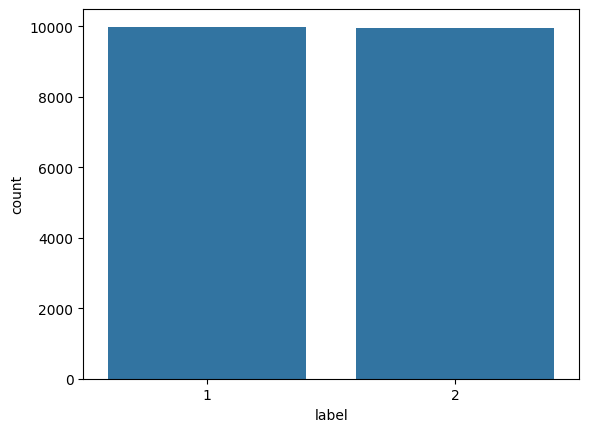

In [21]:
sns.countplot(x=df['label'])

In [22]:
import numpy as np; print(np.__version__)

1.25.2


In [23]:
#SLICE_SIZE = 5_000
#df_slice_1 = df[:SLICE_SIZE // 2].copy()
#df_slice_2 = df[df.shape[0] // 2: df.shape[0] // 2 + SLICE_SIZE // 2].copy()
#df_slice_2.index = np.arange(SLICE_SIZE // 2, SLICE_SIZE)
#df_slice = pd.concat([df_slice_1, df_slice_2])
df_slice = df # originally we did some tests with smaller DataFrame sizes. Now this cell is simply an alias for the same DataFrame

In [24]:
X = []
for sentence in list(df_slice['text']):
    X.append(sentence)
# X just contains all the review texts (in Sentiment Analysis usually referred to as 'sentences')

<Axes: ylabel='count'>

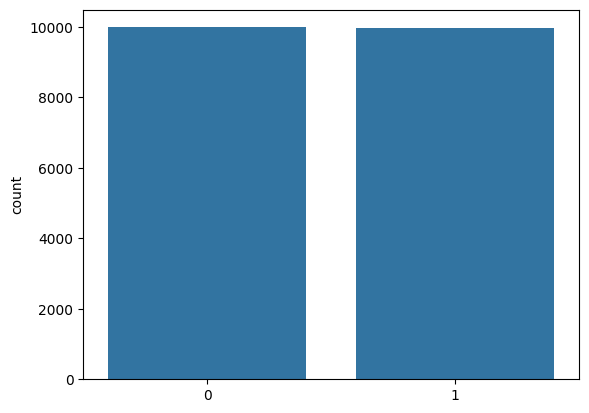

In [25]:
y = list(df_slice['label'])
y = np.array(list(map(lambda x: 1 if x == 2 or x == '2' else 0, y)))
# y is an array of labels. We want it to be an np.array type in order for the validation split to be possible in fitting the model

sns.countplot(x=y)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# initial split

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# turn input sentences into sequences of tokens

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
import torch

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
device

device(type='cuda', index=0)

In [34]:
vocab_size = len(tokenizer.word_index) + 1
# every key is another word in the vocabulary. The + 1 is because of reserving padding

max_length = 100

X_train = pad_sequences(X_train, padding = 'post', maxlen = max_length)
X_test = pad_sequences(X_test , padding = 'post', maxlen = max_length)

X_train = np.array(X_train)
X_test = np.array(X_test)
# turn then into np.array type so that the validation split in fitting works

In [35]:
EMBEDDINGS_MATRIX_FILE = 'embeddings_matrix.pkl'

embedding_matrix = load_from_pickle(EMBEDDINGS_MATRIX_FILE)

embeddings_dictionary = None
if embedding_matrix is None:
    embeddings_dictionary = dict()
    glove_file = open('glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

Loading embeddings_matrix.pkl from pickle file...


In [36]:
if embedding_matrix is None:
    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    save_to_pickle(embedding_matrix, EMBEDDINGS_MATRIX_FILE)

In [37]:
# embedding_matrix is 2D of shape (vocab_size, 100). Since we are using glove.6B.100d.txt
# for the embeddings each one of our words is associated with a weight vector of size 100

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization


In [39]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
lstm_layer_sizes = (256, 128)

In [41]:
# If a GPU is available the keras model will automatically use it for computations

In [42]:
model = Sequential([
    # input the word tokens and generate the embeddings. The generated embeddings have size 100, as we explained earlier
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Dropout(0.2),
    # the bidirectional LSTM layer aims to capture information from both directions
    Bidirectional(LSTM(lstm_layer_sizes[0], return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(lstm_layer_sizes[1]), # this LSTM layer is smaller than the first and aims to further process the temporal features
    # capturing higher-level temporal dependencies
    Dense(lstm_layer_sizes[1], activation='relu'), # this fully connected layer aims to
    # learn from the output of the LSTM layers.
    Dense(1, activation='sigmoid') # sigmoid helps giving a probability between 0 and 1
    # output is just 1 element
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# as we have seen in previous laboratories the Adam optimizer is usually the best and fastest choice
# since it combines well most of the optimizing ideas
# the binary crossentropy as a loss function is typicall for classification problems

In [43]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2,verbose=1)
# batch_size: number of samples per gradient update
# epochs: number of epochs to train the model
# validation_split: fraction of the training data to be used as validation data.
# The model will set appart this fraction of the training data, will not train on it,
# and will evaluate the loss and any model metrics on this data at the end of each epoch.

Epoch 1/10
100/100 [==============================] - 20s 57ms/step - loss: 0.6992 - accuracy: 0.4989 - val_loss: 0.6938 - val_accuracy: 0.5069
Epoch 2/10
100/100 [==============================] - 5s 49ms/step - loss: 0.6785 - accuracy: 0.5672 - val_loss: 0.6933 - val_accuracy: 0.5078
Epoch 3/10
100/100 [==============================] - 5s 45ms/step - loss: 0.5534 - accuracy: 0.7393 - val_loss: 0.5308 - val_accuracy: 0.7375
Epoch 4/10
100/100 [==============================] - 5s 46ms/step - loss: 0.4678 - accuracy: 0.7871 - val_loss: 0.6392 - val_accuracy: 0.7206
Epoch 5/10
100/100 [==============================] - 5s 48ms/step - loss: 0.4107 - accuracy: 0.8173 - val_loss: 0.4392 - val_accuracy: 0.8026
Epoch 6/10
100/100 [==============================] - 5s 46ms/step - loss: 0.3937 - accuracy: 0.8244 - val_loss: 0.4097 - val_accuracy: 0.8186
Epoch 7/10
100/100 [==============================] - 5s 46ms/step - loss: 0.3714 - accuracy: 0.8381 - val_loss: 0.4955 - val_accuracy: 0.766

In [44]:
model.save('model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
score = model.evaluate(X_test, y_test, verbose=1)

125/125 [==============================] - 1s 9ms/step - loss: 0.3619 - accuracy: 0.8421


In [46]:
import matplotlib.pyplot as plt

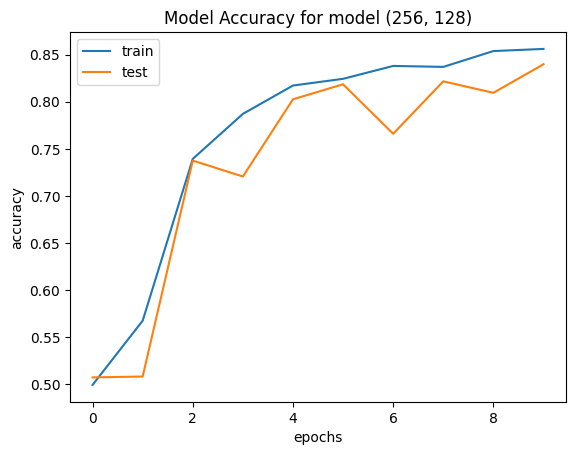

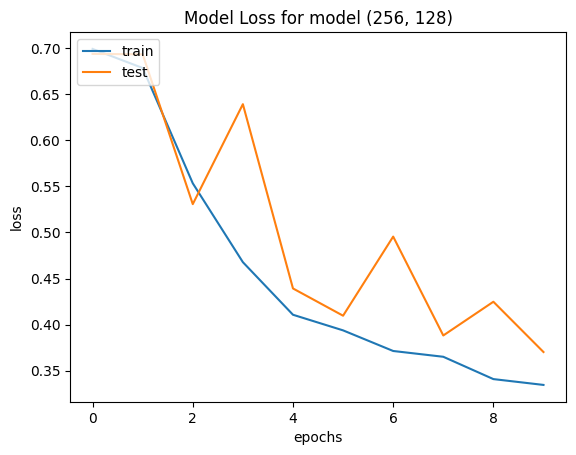

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title(f'Model Accuracy for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f'Model Loss for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

In [48]:
# classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix


In [49]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print(f'Metrics for model {lstm_layer_sizes}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


125/125 [==============================] - 2s 7ms/step
Metrics for model (256, 128)
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1945
           1       0.87      0.82      0.84      2045

    accuracy                           0.84      3990
   macro avg       0.84      0.84      0.84      3990
weighted avg       0.84      0.84      0.84      3990

[[1686  259]
 [ 371 1674]]


In [50]:
lstm_layer_sizes = (128, 64)

In [51]:
# now let's do one with half the neurons

In [52]:
model_128 = Sequential([
    # input the word tokens and generate the embeddings. The generated embeddings have size 100, as we explained earlier
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Dropout(0.2),
    # the bidirectional LSTM layer aims to capture information from both directions
    Bidirectional(LSTM(lstm_layer_sizes[0], return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(lstm_layer_sizes[1]), # this LSTM layer is smaller than the first and aims to further process the temporal features
    # capturing higher-level temporal dependencies
    Dense(lstm_layer_sizes[1], activation='relu'), # this fully connected layer aims to
    # learn from the output of the LSTM layers.
    Dense(1, activation='sigmoid') # sigmoid helps giving a probability between 0 and 1
    # output is just 1 element
])

model_128.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# as we have seen in previous laboratories the Adam optimizer is usually the best and fastest choice
# since it combines well most of the optimizing ideas
# the binary crossentropy as a loss function is typicall for classification problems

In [53]:
history = model_128.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2,verbose=1)

Epoch 1/10
100/100 [==============================] - 11s 37ms/step - loss: 0.6953 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.4962
Epoch 2/10
100/100 [==============================] - 2s 25ms/step - loss: 0.6594 - accuracy: 0.6041 - val_loss: 0.6970 - val_accuracy: 0.4966
Epoch 3/10
100/100 [==============================] - 2s 25ms/step - loss: 0.5645 - accuracy: 0.7351 - val_loss: 0.4977 - val_accuracy: 0.7901
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 0.4549 - accuracy: 0.8055 - val_loss: 0.5743 - val_accuracy: 0.7685
Epoch 5/10
100/100 [==============================] - 3s 29ms/step - loss: 0.4051 - accuracy: 0.8252 - val_loss: 0.5634 - val_accuracy: 0.7234
Epoch 6/10
100/100 [==============================] - 3s 26ms/step - loss: 0.3900 - accuracy: 0.8279 - val_loss: 0.3919 - val_accuracy: 0.8371
Epoch 7/10
100/100 [==============================] - 3s 26ms/step - loss: 0.3701 - accuracy: 0.8390 - val_loss: 0.3787 - val_accuracy: 0.834

In [54]:
model_128.save('model128.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
score = model_128.evaluate(X_test, y_test, verbose=1)

125/125 [==============================] - 1s 8ms/step - loss: 0.3539 - accuracy: 0.8461


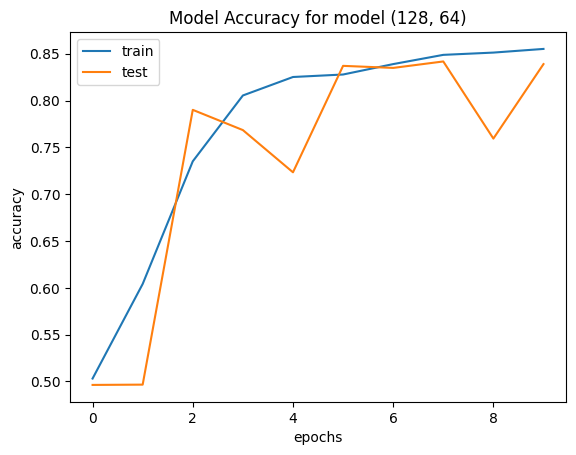

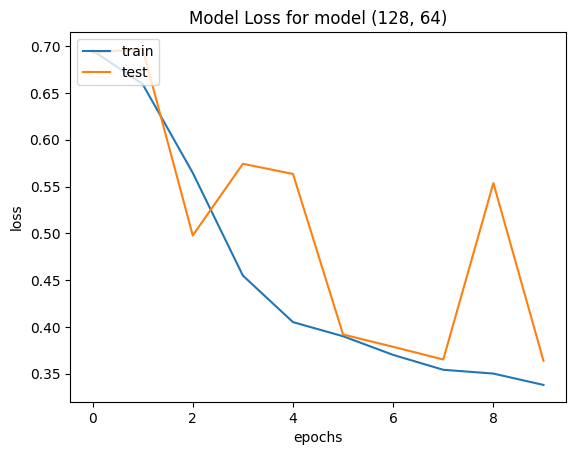

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title(f'Model Accuracy for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f'Model Loss for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

In [57]:
y_pred = model_128.predict(X_test)
y_pred = (y_pred > 0.5)

print(f'Metrics for model {lstm_layer_sizes}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


125/125 [==============================] - 2s 6ms/step
Metrics for model (128, 64)
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1945
           1       0.84      0.86      0.85      2045

    accuracy                           0.85      3990
   macro avg       0.85      0.85      0.85      3990
weighted avg       0.85      0.85      0.85      3990

[[1613  332]
 [ 282 1763]]


In [58]:
lstm_layer_sizes = (512, 128)

In [59]:
# and one with double the neurons

In [60]:
model_512 = Sequential([
    # input the word tokens and generate the embeddings. The generated embeddings have size 100, as we explained earlier
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Dropout(0.2),
    # the bidirectional LSTM layer aims to capture information from both directions
    Bidirectional(LSTM(lstm_layer_sizes[0], return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(lstm_layer_sizes[1]), # this LSTM layer is smaller than the first and aims to further process the temporal features
    # capturing higher-level temporal dependencies
    Dense(lstm_layer_sizes[1], activation='relu'), # this fully connected layer aims to
    # learn from the output of the LSTM layers.
    Dense(1, activation='sigmoid') # sigmoid helps giving a probability between 0 and 1
    # output is just 1 element
])

model_512.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# as we have seen in previous laboratories the Adam optimizer is usually the best and fastest choice
# since it combines well most of the optimizing ideas
# the binary crossentropy as a loss function is typicall for classification problems

In [61]:
history = model_512.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2,verbose=1)

Epoch 1/10
100/100 [==============================] - 19s 125ms/step - loss: 0.6966 - accuracy: 0.5118 - val_loss: 0.6937 - val_accuracy: 0.5150
Epoch 2/10
100/100 [==============================] - 11s 114ms/step - loss: 0.6411 - accuracy: 0.6392 - val_loss: 0.5900 - val_accuracy: 0.7011
Epoch 3/10
100/100 [==============================] - 11s 110ms/step - loss: 0.5721 - accuracy: 0.7114 - val_loss: 0.5433 - val_accuracy: 0.7447
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 0.5447 - accuracy: 0.7314 - val_loss: 0.4974 - val_accuracy: 0.7578
Epoch 5/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4955 - accuracy: 0.7701 - val_loss: 0.4840 - val_accuracy: 0.7741
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4546 - accuracy: 0.7859 - val_loss: 0.4771 - val_accuracy: 0.7920
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4231 - accuracy: 0.8105 - val_loss: 0.4293 - val_ac

In [62]:
model_512.save('model512.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
score = model_512.evaluate(X_test, y_test, verbose=1)

125/125 [==============================] - 2s 16ms/step - loss: 0.4642 - accuracy: 0.7875


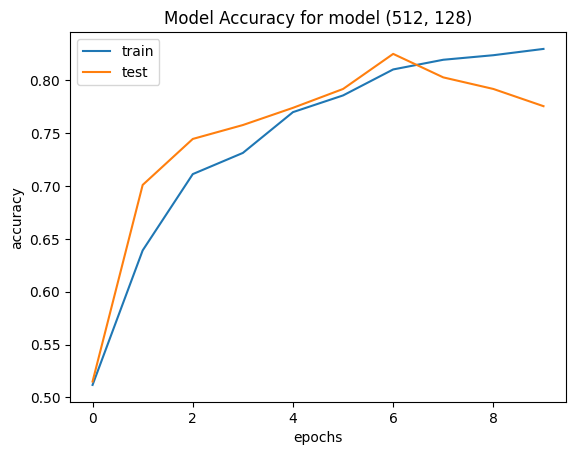

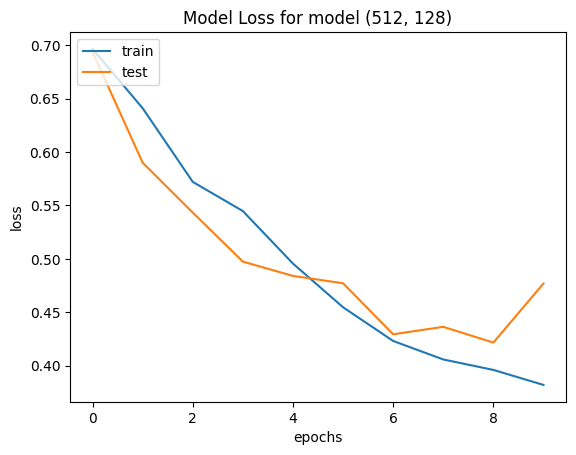

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title(f'Model Accuracy for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f'Model Loss for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

In [65]:
y_pred = model_512.predict(X_test)
y_pred = (y_pred > 0.5)

print(f'Metrics for model {lstm_layer_sizes}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


125/125 [==============================] - 3s 14ms/step
Metrics for model (512, 128)
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      1945
           1       0.92      0.64      0.75      2045

    accuracy                           0.79      3990
   macro avg       0.82      0.79      0.78      3990
weighted avg       0.82      0.79      0.78      3990

[[1839  106]
 [ 742 1303]]


In [66]:
lstm_layer_sizes = (256, 64)

In [67]:
model_mix = Sequential([
    # input the word tokens and generate the embeddings. The generated embeddings have size 100, as we explained earlier
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Dropout(0.2),
    # the bidirectional LSTM layer aims to capture information from both directions
    Bidirectional(LSTM(lstm_layer_sizes[0], return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(lstm_layer_sizes[1]), # this LSTM layer is smaller than the first and aims to further process the temporal features
    # capturing higher-level temporal dependencies
    Dense(lstm_layer_sizes[1], activation='relu'), # this fully connected layer aims to
    # learn from the output of the LSTM layers.
    Dense(1, activation='sigmoid') # sigmoid helps giving a probability between 0 and 1
    # output is just 1 element
])

model_mix.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# as we have seen in previous laboratories the Adam optimizer is usually the best and fastest choice
# since it combines well most of the optimizing ideas
# the binary crossentropy as a loss function is typicall for classification problems

In [68]:
history = model_mix.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2,verbose=1)

Epoch 1/10
100/100 [==============================] - 11s 57ms/step - loss: 0.6958 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5075
Epoch 2/10
100/100 [==============================] - 5s 47ms/step - loss: 0.6471 - accuracy: 0.6426 - val_loss: 0.6642 - val_accuracy: 0.6808
Epoch 3/10
100/100 [==============================] - 5s 47ms/step - loss: 0.5539 - accuracy: 0.7277 - val_loss: 0.5461 - val_accuracy: 0.7487
Epoch 4/10
100/100 [==============================] - 4s 45ms/step - loss: 0.4241 - accuracy: 0.8102 - val_loss: 0.6139 - val_accuracy: 0.7227
Epoch 5/10
100/100 [==============================] - 4s 44ms/step - loss: 0.3900 - accuracy: 0.8260 - val_loss: 0.3989 - val_accuracy: 0.8261
Epoch 6/10
100/100 [==============================] - 5s 46ms/step - loss: 0.3749 - accuracy: 0.8348 - val_loss: 0.4410 - val_accuracy: 0.7892
Epoch 7/10
100/100 [==============================] - 5s 48ms/step - loss: 0.3614 - accuracy: 0.8425 - val_loss: 0.6935 - val_accuracy: 0.703

In [69]:
model_mix.save('modelmix.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
score = model_mix.evaluate(X_test, y_test, verbose=1)

125/125 [==============================] - 1s 9ms/step - loss: 0.3537 - accuracy: 0.8476


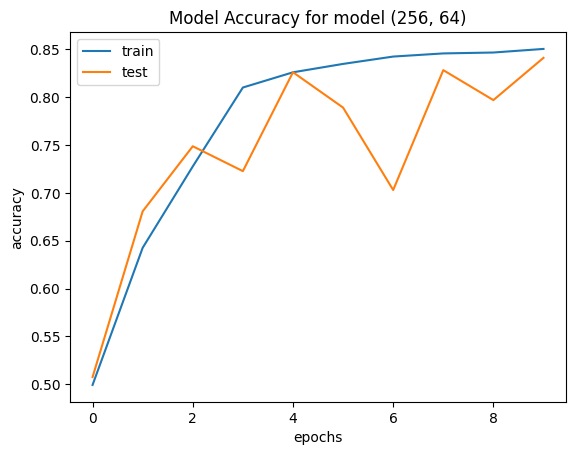

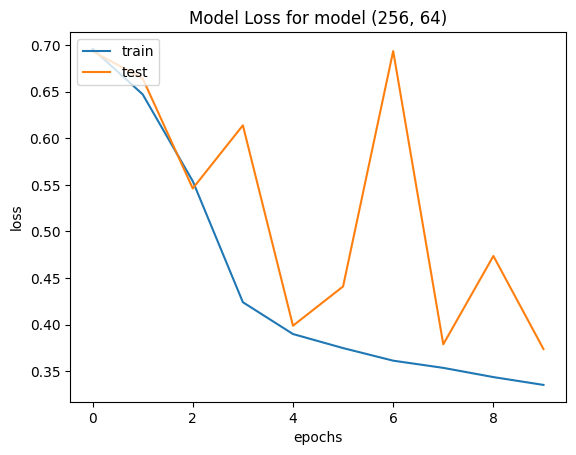

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title(f'Model Accuracy for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f'Model Loss for model {lstm_layer_sizes}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train' , 'test'], loc = 'upper left')
plt.show()

In [72]:
y_pred = model_mix.predict(X_test)
y_pred = (y_pred > 0.5)

print(f'Metrics for model {lstm_layer_sizes}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


125/125 [==============================] - 2s 8ms/step
Metrics for model (256, 64)
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1945
           1       0.87      0.83      0.85      2045

    accuracy                           0.85      3990
   macro avg       0.85      0.85      0.85      3990
weighted avg       0.85      0.85      0.85      3990

[[1694  251]
 [ 357 1688]]
